## Import

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from itertools import chain

# for reading and displaying images
# from skimage.io import imread
import matplotlib.pyplot as plt
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# models
from src.architectures.resnet import *
from src.architectures.levakov_96 import *
from src.architectures.inception import *
from src.architectures.dinsdale import *

# other files
from src.run import *

# Torch
from torch.optim import *
import torch.optim as optim
from torchsummary import summary
from tensorboardX import SummaryWriter

# CAM - M3dCam
from medcam import medcam

## Dataloader
for kFold, it will be run again on the run

In [2]:
from src.dataloader import *

train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

## Load Model

In [3]:
def load_model(model, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Model {model.capitalize()} is selected.')

    if model == 'resnet':
        

        opt = Option()
        model = generate_model(model_depth=opt.model_depth,
                                    n_classes=opt.n_classes,
                                    n_input_channels=opt.n_input_channels,
                                    shortcut_type=opt.shortcut_type,
                                    conv1_t_size=opt.conv1_t_size,
                                    conv1_t_stride=opt.conv1_t_stride,
                                    no_max_pool=opt.no_max_pool,
                                    widen_factor=opt.resnet_widen_factor)

    elif model == 'levakov':
        model = Levakov(task_type='age')

    elif model == 'inception':
        model = Inception3()

    elif model == 'dinsdale':
        model = Dinsdale(1, 1, 2)

    else: return None

    model.to(device)
    if verbose:
        print(summary(model, input_size=(1, 96, 96, 96)))
    
    return model, device

model = 'resnet'
model, device = load_model(model)
# model = medcam.inject(model, output_dir="attention_maps", save_maps=True)

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

## Setups

Default Settings

In [4]:
task_type = 'age' # no longer used.
resize = True
scheduler = False
epochs = range(200)
folds = range(10)

Loss & Optimizer

In [5]:
from src.losses import RMSELoss

loss_fn = nn.MSELoss()
lamb = 0.0005
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

Metrics

In [6]:
rmse_fn = RMSELoss()
mae_fn = nn.L1Loss()

## Run

### without Folds

EPOCHS 1 / 200
MAE  :: [TRAIN] 1.193   | [TEST] 6.792


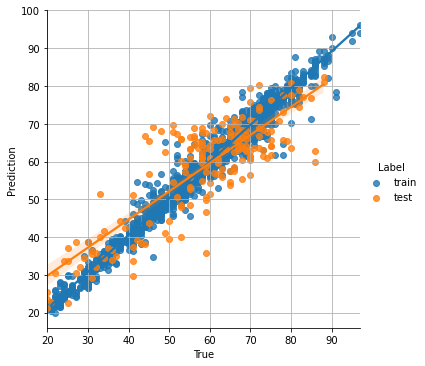

MSE  :: [TRAIN] 3.193 | [VALID] 70.734
RMSE :: [TRAIN] 1.556  | [VALID] 8.380
CORR :: [TRAIN] 0.987 | [VALID] 0.842

EPOCHS 2 / 200
MAE  :: [TRAIN] 1.134   | [TEST] 6.829
EPOCHS 3 / 200
MAE  :: [TRAIN] 1.157   | [TEST] 6.859
EPOCHS 4 / 200
MAE  :: [TRAIN] 1.072   | [TEST] 6.709
EPOCHS 5 / 200
MAE  :: [TRAIN] 1.038   | [TEST] 6.767
EPOCHS 6 / 200
MAE  :: [TRAIN] 1.000   | [TEST] 6.801


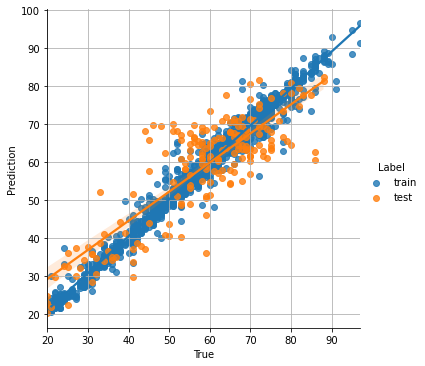

MSE  :: [TRAIN] 2.522 | [VALID] 71.934
RMSE :: [TRAIN] 1.334  | [VALID] 8.445
CORR :: [TRAIN] 0.989 | [VALID] 0.841

EPOCHS 7 / 200
MAE  :: [TRAIN] 0.989   | [TEST] 6.886
EPOCHS 8 / 200
MAE  :: [TRAIN] 0.964   | [TEST] 6.915
EPOCHS 9 / 200
MAE  :: [TRAIN] 0.951   | [TEST] 6.880
EPOCHS 10 / 200
MAE  :: [TRAIN] 0.942   | [TEST] 6.689


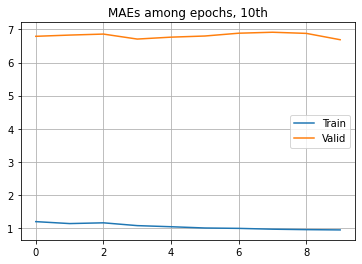

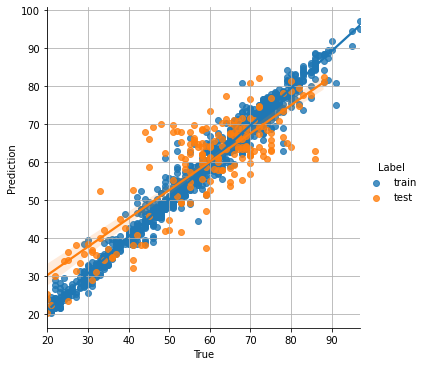

EPOCHS 11 / 200
MAE  :: [TRAIN] 0.917   | [TEST] 6.808


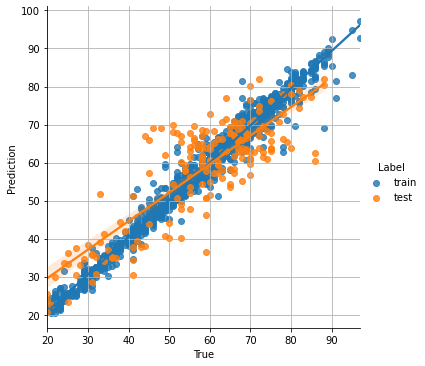

MSE  :: [TRAIN] 2.210 | [VALID] 71.187
RMSE :: [TRAIN] 1.212  | [VALID] 8.406
CORR :: [TRAIN] 0.990 | [VALID] 0.841

EPOCHS 12 / 200
MAE  :: [TRAIN] 0.894   | [TEST] 6.895
EPOCHS 13 / 200
MAE  :: [TRAIN] 0.871   | [TEST] 6.739
EPOCHS 14 / 200
MAE  :: [TRAIN] 0.884   | [TEST] 6.798
EPOCHS 15 / 200
MAE  :: [TRAIN] 0.855   | [TEST] 6.874
EPOCHS 16 / 200
MAE  :: [TRAIN] 0.870   | [TEST] 6.819


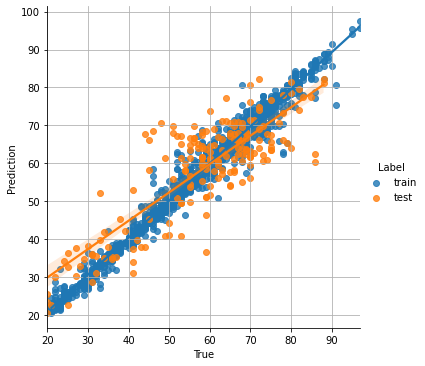

MSE  :: [TRAIN] 2.071 | [VALID] 71.910
RMSE :: [TRAIN] 1.162  | [VALID] 8.446
CORR :: [TRAIN] 0.989 | [VALID] 0.838

EPOCHS 17 / 200
MAE  :: [TRAIN] 0.866   | [TEST] 6.912
EPOCHS 18 / 200
MAE  :: [TRAIN] 0.829   | [TEST] 6.846
EPOCHS 19 / 200
MAE  :: [TRAIN] 0.826   | [TEST] 6.796
EPOCHS 20 / 200
MAE  :: [TRAIN] 0.827   | [TEST] 6.831


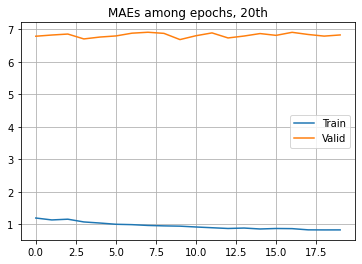

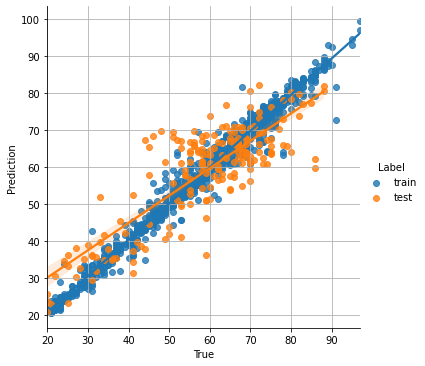

EPOCHS 21 / 200
MAE  :: [TRAIN] 0.793   | [TEST] 6.870


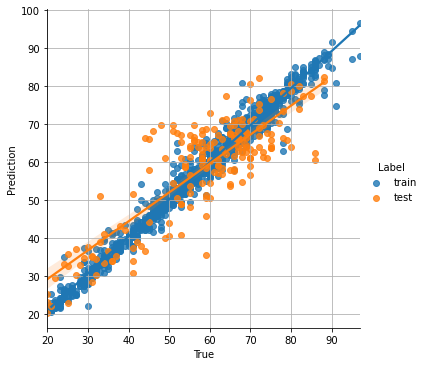

MSE  :: [TRAIN] 1.862 | [VALID] 72.283
RMSE :: [TRAIN] 1.068  | [VALID] 8.465
CORR :: [TRAIN] 0.991 | [VALID] 0.842

EPOCHS 22 / 200
MAE  :: [TRAIN] 0.797   | [TEST] 6.933
EPOCHS 23 / 200
MAE  :: [TRAIN] 0.765   | [TEST] 6.837
EPOCHS 24 / 200
MAE  :: [TRAIN] 0.755   | [TEST] 6.803
EPOCHS 25 / 200
MAE  :: [TRAIN] 0.760   | [TEST] 6.784
EPOCHS 26 / 200
MAE  :: [TRAIN] 0.725   | [TEST] 6.884


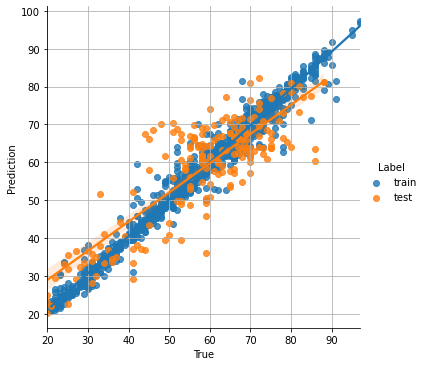

MSE  :: [TRAIN] 1.705 | [VALID] 72.866
RMSE :: [TRAIN] 0.985  | [VALID] 8.499
CORR :: [TRAIN] 0.990 | [VALID] 0.841

EPOCHS 27 / 200
MAE  :: [TRAIN] 0.770   | [TEST] 6.902
EPOCHS 28 / 200
MAE  :: [TRAIN] 0.756   | [TEST] 7.041
EPOCHS 29 / 200
MAE  :: [TRAIN] 0.749   | [TEST] 6.720
EPOCHS 30 / 200
MAE  :: [TRAIN] 0.703   | [TEST] 6.812


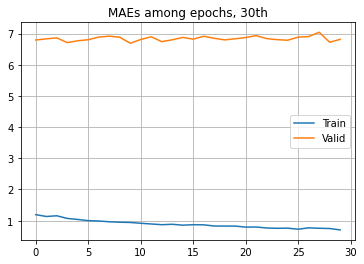

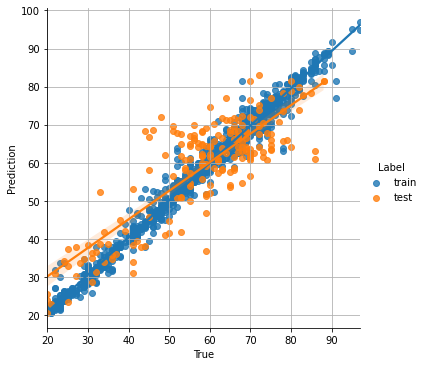

EPOCHS 31 / 200
MAE  :: [TRAIN] 0.706   | [TEST] 6.855


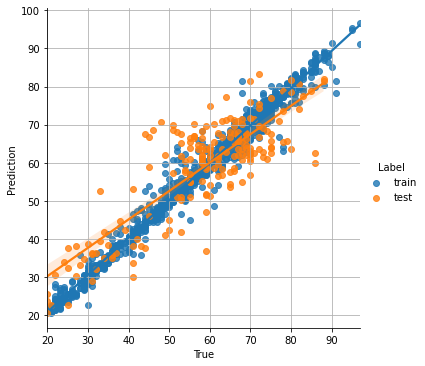

MSE  :: [TRAIN] 1.640 | [VALID] 73.264
RMSE :: [TRAIN] 0.953  | [VALID] 8.517
CORR :: [TRAIN] 0.992 | [VALID] 0.837

EPOCHS 32 / 200
MAE  :: [TRAIN] 0.714   | [TEST] 6.934
EPOCHS 33 / 200
MAE  :: [TRAIN] 0.720   | [TEST] 6.813
EPOCHS 34 / 200
MAE  :: [TRAIN] 0.703   | [TEST] 6.892
EPOCHS 35 / 200
MAE  :: [TRAIN] 0.706   | [TEST] 6.836
EPOCHS 36 / 200
MAE  :: [TRAIN] 0.647   | [TEST] 6.905


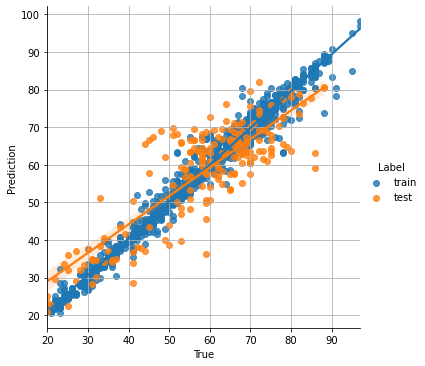

MSE  :: [TRAIN] 1.520 | [VALID] 72.245
RMSE :: [TRAIN] 0.888  | [VALID] 8.470
CORR :: [TRAIN] 0.991 | [VALID] 0.841

EPOCHS 37 / 200
MAE  :: [TRAIN] 0.696   | [TEST] 6.819
EPOCHS 38 / 200
MAE  :: [TRAIN] 0.678   | [TEST] 6.834
EPOCHS 39 / 200
MAE  :: [TRAIN] 0.656   | [TEST] 6.790
EPOCHS 40 / 200
MAE  :: [TRAIN] 0.671   | [TEST] 6.778


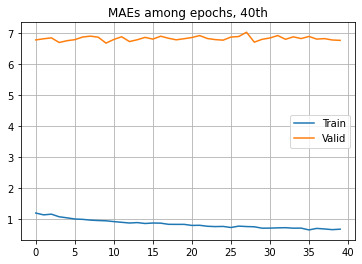

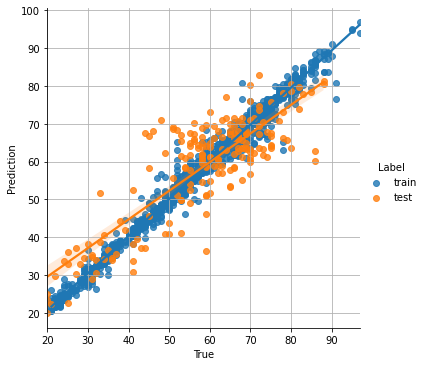

EPOCHS 41 / 200
MAE  :: [TRAIN] 0.648   | [TEST] 6.802


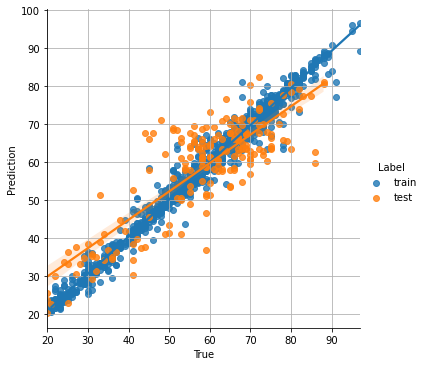

MSE  :: [TRAIN] 1.496 | [VALID] 71.864
RMSE :: [TRAIN] 0.877  | [VALID] 8.442
CORR :: [TRAIN] 0.991 | [VALID] 0.840

EPOCHS 42 / 200
MAE  :: [TRAIN] 0.677   | [TEST] 6.769
EPOCHS 43 / 200
MAE  :: [TRAIN] 0.666   | [TEST] 6.798
EPOCHS 44 / 200
MAE  :: [TRAIN] 0.657   | [TEST] 6.807
EPOCHS 45 / 200
MAE  :: [TRAIN] 0.656   | [TEST] 6.900
EPOCHS 46 / 200
MAE  :: [TRAIN] 0.637   | [TEST] 6.799


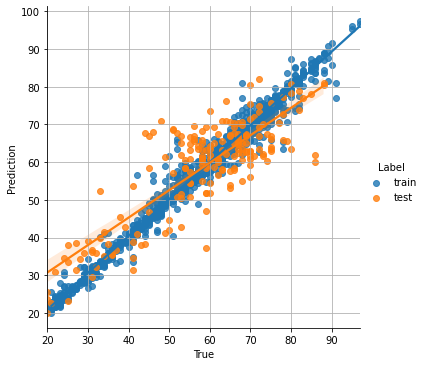

MSE  :: [TRAIN] 1.478 | [VALID] 72.147
RMSE :: [TRAIN] 0.872  | [VALID] 8.452
CORR :: [TRAIN] 0.991 | [VALID] 0.837

EPOCHS 47 / 200
MAE  :: [TRAIN] 0.647   | [TEST] 6.924
EPOCHS 48 / 200
MAE  :: [TRAIN] 0.635   | [TEST] 6.931
EPOCHS 49 / 200
MAE  :: [TRAIN] 0.618   | [TEST] 6.868
EPOCHS 50 / 200
MAE  :: [TRAIN] 0.614   | [TEST] 6.828


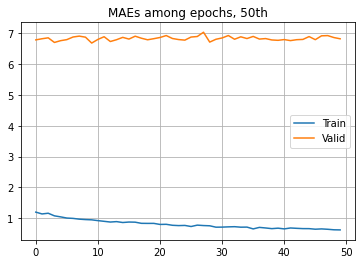

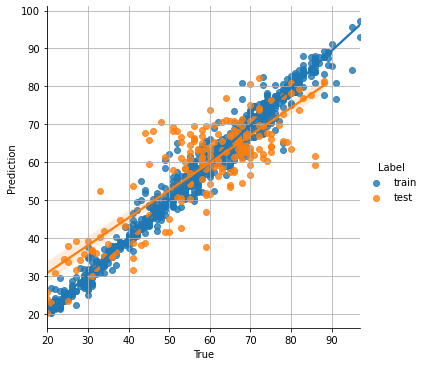

EPOCHS 51 / 200
MAE  :: [TRAIN] 0.684   | [TEST] 6.841


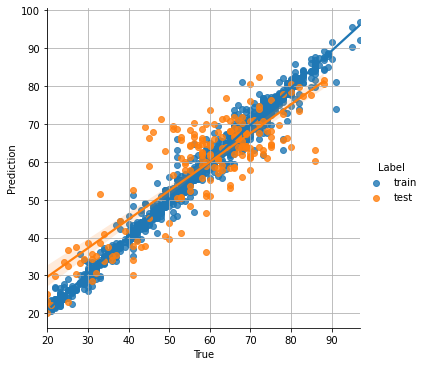

MSE  :: [TRAIN] 1.525 | [VALID] 72.701
RMSE :: [TRAIN] 0.906  | [VALID] 8.489
CORR :: [TRAIN] 0.992 | [VALID] 0.839

EPOCHS 52 / 200
MAE  :: [TRAIN] 0.589   | [TEST] 6.948
EPOCHS 53 / 200
MAE  :: [TRAIN] 0.611   | [TEST] 6.775
EPOCHS 54 / 200
MAE  :: [TRAIN] 0.633   | [TEST] 7.090
EPOCHS 55 / 200
MAE  :: [TRAIN] 0.613   | [TEST] 6.790
EPOCHS 56 / 200
MAE  :: [TRAIN] 0.596   | [TEST] 6.817


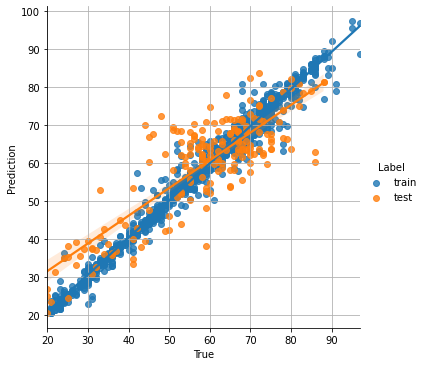

MSE  :: [TRAIN] 1.394 | [VALID] 73.541
RMSE :: [TRAIN] 0.813  | [VALID] 8.521
CORR :: [TRAIN] 0.991 | [VALID] 0.835

EPOCHS 57 / 200
MAE  :: [TRAIN] 0.589   | [TEST] 6.870
EPOCHS 58 / 200
MAE  :: [TRAIN] 0.634   | [TEST] 6.911
EPOCHS 59 / 200
MAE  :: [TRAIN] 0.607   | [TEST] 6.754
EPOCHS 60 / 200
MAE  :: [TRAIN] 0.606   | [TEST] 6.897


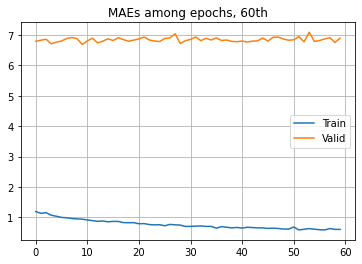

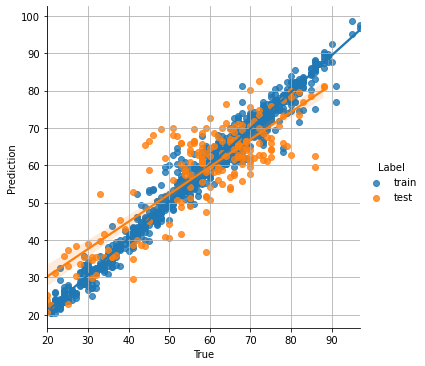

EPOCHS 61 / 200
MAE  :: [TRAIN] 0.660   | [TEST] 6.903


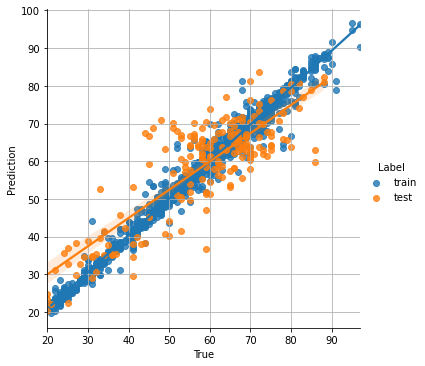

MSE  :: [TRAIN] 1.490 | [VALID] 73.492
RMSE :: [TRAIN] 0.886  | [VALID] 8.532
CORR :: [TRAIN] 0.991 | [VALID] 0.836

EPOCHS 62 / 200
MAE  :: [TRAIN] 0.578   | [TEST] 6.970
EPOCHS 63 / 200
MAE  :: [TRAIN] 0.548   | [TEST] 6.875
EPOCHS 64 / 200
MAE  :: [TRAIN] 0.565   | [TEST] 6.810
EPOCHS 65 / 200
MAE  :: [TRAIN] 0.579   | [TEST] 6.747
EPOCHS 66 / 200
MAE  :: [TRAIN] 0.560   | [TEST] 6.833


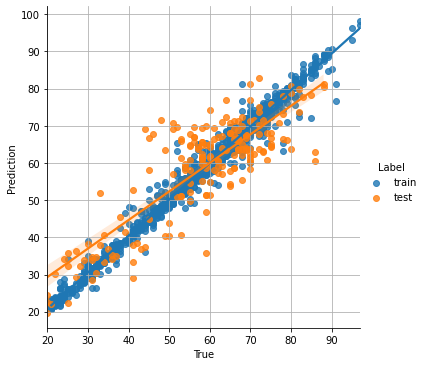

MSE  :: [TRAIN] 1.334 | [VALID] 73.017
RMSE :: [TRAIN] 0.778  | [VALID] 8.506
CORR :: [TRAIN] 0.992 | [VALID] 0.839

EPOCHS 67 / 200
MAE  :: [TRAIN] 0.578   | [TEST] 6.848
EPOCHS 68 / 200
MAE  :: [TRAIN] 0.566   | [TEST] 6.913
EPOCHS 69 / 200
MAE  :: [TRAIN] 0.581   | [TEST] 6.830
EPOCHS 70 / 200
MAE  :: [TRAIN] 0.556   | [TEST] 6.872


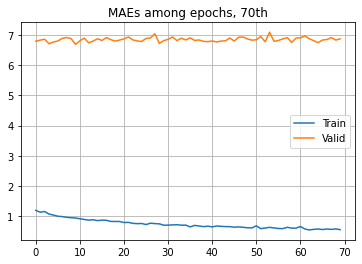

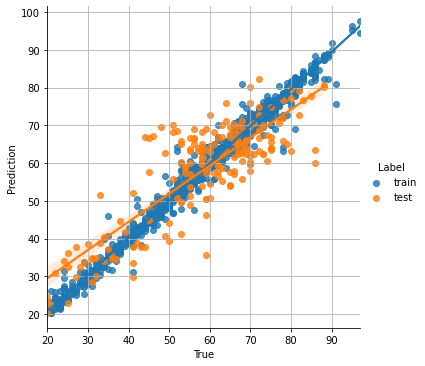

EPOCHS 71 / 200
MAE  :: [TRAIN] 0.561   | [TEST] 6.902


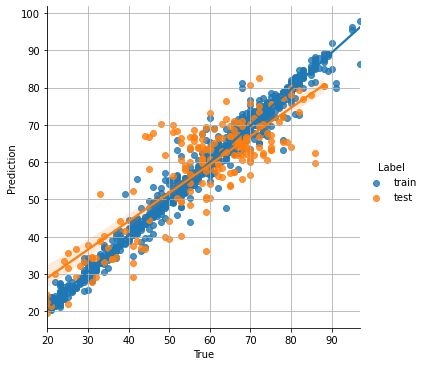

MSE  :: [TRAIN] 1.334 | [VALID] 73.268
RMSE :: [TRAIN] 0.774  | [VALID] 8.524
CORR :: [TRAIN] 0.992 | [VALID] 0.840

EPOCHS 72 / 200
MAE  :: [TRAIN] 0.582   | [TEST] 6.904
EPOCHS 73 / 200
MAE  :: [TRAIN] 0.604   | [TEST] 6.826
EPOCHS 74 / 200
MAE  :: [TRAIN] 0.556   | [TEST] 6.960
EPOCHS 75 / 200
MAE  :: [TRAIN] 0.572   | [TEST] 6.893
EPOCHS 76 / 200
MAE  :: [TRAIN] 0.553   | [TEST] 6.862


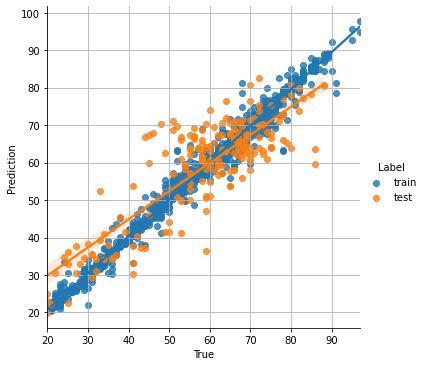

MSE  :: [TRAIN] 1.338 | [VALID] 72.969
RMSE :: [TRAIN] 0.777  | [VALID] 8.499
CORR :: [TRAIN] 0.992 | [VALID] 0.838

EPOCHS 77 / 200
MAE  :: [TRAIN] 0.585   | [TEST] 6.930
EPOCHS 78 / 200
MAE  :: [TRAIN] 0.549   | [TEST] 6.901
EPOCHS 79 / 200
MAE  :: [TRAIN] 0.550   | [TEST] 6.829
EPOCHS 80 / 200
MAE  :: [TRAIN] 0.556   | [TEST] 6.852


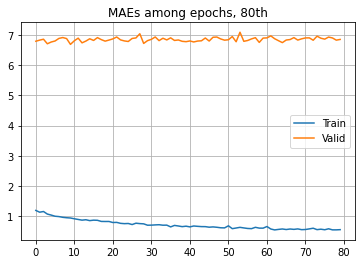

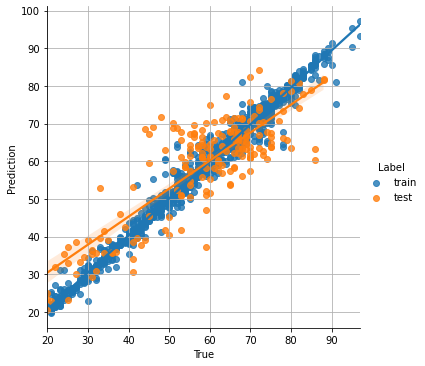

EPOCHS 81 / 200
MAE  :: [TRAIN] 0.558   | [TEST] 6.881


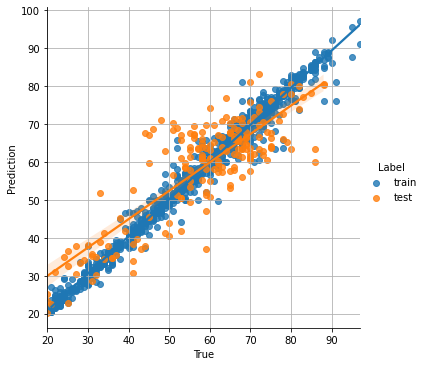

MSE  :: [TRAIN] 1.342 | [VALID] 73.289
RMSE :: [TRAIN] 0.782  | [VALID] 8.518
CORR :: [TRAIN] 0.992 | [VALID] 0.838

EPOCHS 82 / 200
MAE  :: [TRAIN] 0.514   | [TEST] 6.901
EPOCHS 83 / 200
MAE  :: [TRAIN] 0.538   | [TEST] 6.927
EPOCHS 84 / 200
MAE  :: [TRAIN] 0.538   | [TEST] 6.924
EPOCHS 85 / 200
MAE  :: [TRAIN] 0.542   | [TEST] 6.933
EPOCHS 86 / 200
MAE  :: [TRAIN] 0.548   | [TEST] 6.961


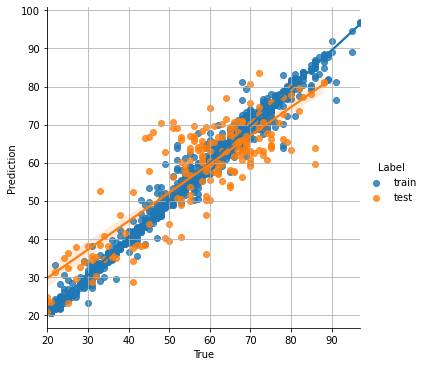

MSE  :: [TRAIN] 1.293 | [VALID] 74.320
RMSE :: [TRAIN] 0.749  | [VALID] 8.578
CORR :: [TRAIN] 0.993 | [VALID] 0.837

EPOCHS 87 / 200
MAE  :: [TRAIN] 0.561   | [TEST] 6.900
EPOCHS 88 / 200
MAE  :: [TRAIN] 0.569   | [TEST] 6.894
EPOCHS 89 / 200
MAE  :: [TRAIN] 0.535   | [TEST] 6.796
EPOCHS 90 / 200
MAE  :: [TRAIN] 0.574   | [TEST] 6.892


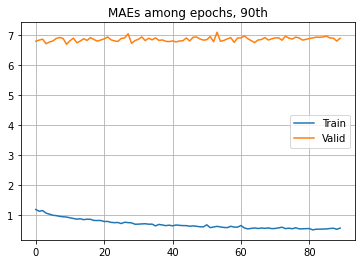

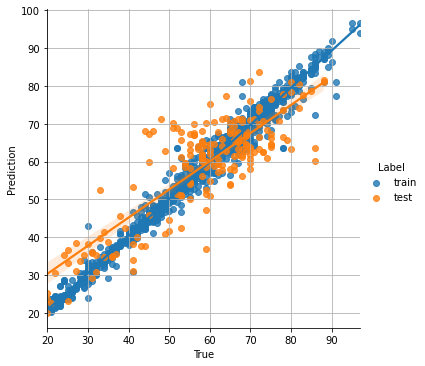

EPOCHS 91 / 200
MAE  :: [TRAIN] 0.508   | [TEST] 6.838


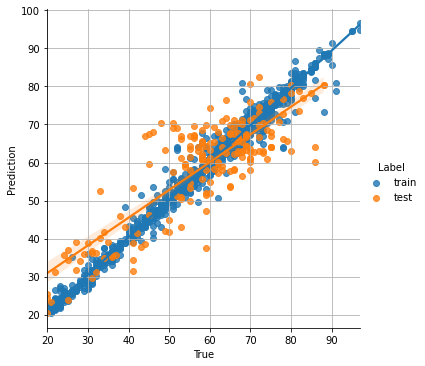

MSE  :: [TRAIN] 1.257 | [VALID] 72.014
RMSE :: [TRAIN] 0.718  | [VALID] 8.438
CORR :: [TRAIN] 0.993 | [VALID] 0.837

EPOCHS 92 / 200
MAE  :: [TRAIN] 0.522   | [TEST] 6.834
EPOCHS 93 / 200
MAE  :: [TRAIN] 0.511   | [TEST] 6.842
EPOCHS 94 / 200
MAE  :: [TRAIN] 0.516   | [TEST] 6.959
EPOCHS 95 / 200
MAE  :: [TRAIN] 0.511   | [TEST] 6.903
EPOCHS 96 / 200
MAE  :: [TRAIN] 0.539   | [TEST] 6.768


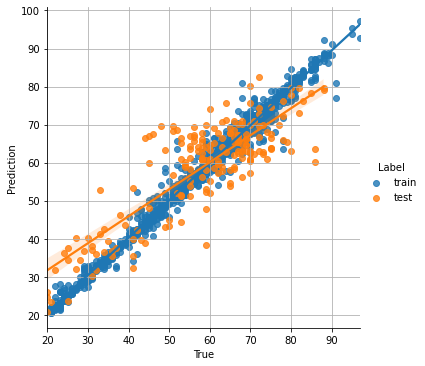

MSE  :: [TRAIN] 1.289 | [VALID] 70.946
RMSE :: [TRAIN] 0.748  | [VALID] 8.372
CORR :: [TRAIN] 0.993 | [VALID] 0.839

EPOCHS 97 / 200
MAE  :: [TRAIN] 0.548   | [TEST] 6.885
EPOCHS 98 / 200
MAE  :: [TRAIN] 0.529   | [TEST] 6.868
EPOCHS 99 / 200
MAE  :: [TRAIN] 0.513   | [TEST] 6.800
EPOCHS 100 / 200
MAE  :: [TRAIN] 0.517   | [TEST] 6.941


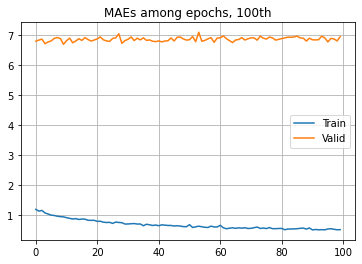

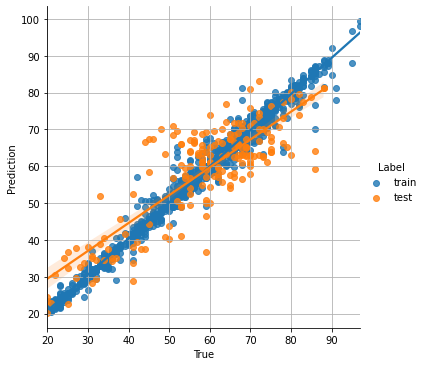

EPOCHS 101 / 200
MAE  :: [TRAIN] 0.513   | [TEST] 6.917


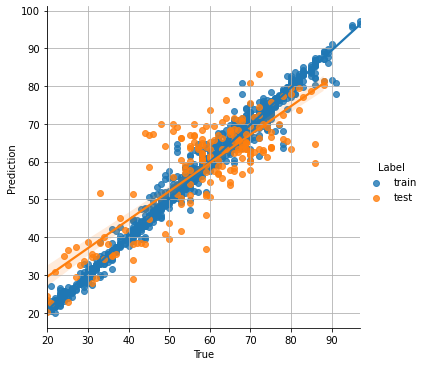

MSE  :: [TRAIN] 1.257 | [VALID] 72.978
RMSE :: [TRAIN] 0.720  | [VALID] 8.498
CORR :: [TRAIN] 0.993 | [VALID] 0.839

EPOCHS 102 / 200
MAE  :: [TRAIN] 0.523   | [TEST] 6.861
EPOCHS 103 / 200
MAE  :: [TRAIN] 0.514   | [TEST] 6.914
EPOCHS 104 / 200
MAE  :: [TRAIN] 0.520   | [TEST] 6.883
EPOCHS 105 / 200
MAE  :: [TRAIN] 0.518   | [TEST] 6.788
EPOCHS 106 / 200
MAE  :: [TRAIN] 0.502   | [TEST] 6.935


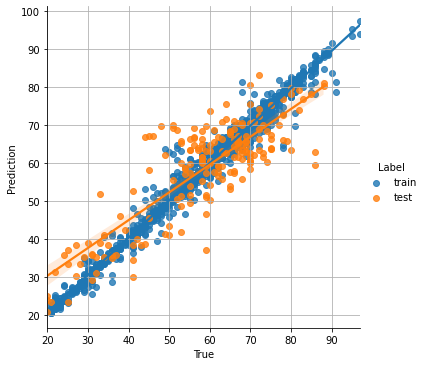

MSE  :: [TRAIN] 1.240 | [VALID] 73.426
RMSE :: [TRAIN] 0.713  | [VALID] 8.525
CORR :: [TRAIN] 0.992 | [VALID] 0.838

EPOCHS 107 / 200
MAE  :: [TRAIN] 0.541   | [TEST] 6.886
EPOCHS 108 / 200
MAE  :: [TRAIN] 0.524   | [TEST] 6.961
EPOCHS 109 / 200
MAE  :: [TRAIN] 0.504   | [TEST] 6.902
EPOCHS 110 / 200
MAE  :: [TRAIN] 0.546   | [TEST] 6.819


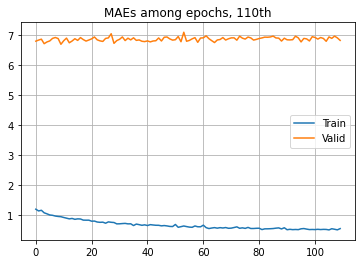

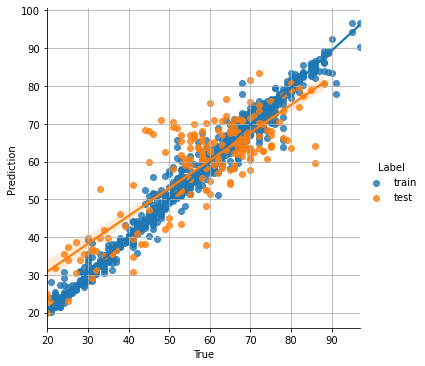

EPOCHS 111 / 200
MAE  :: [TRAIN] 0.513   | [TEST] 6.902


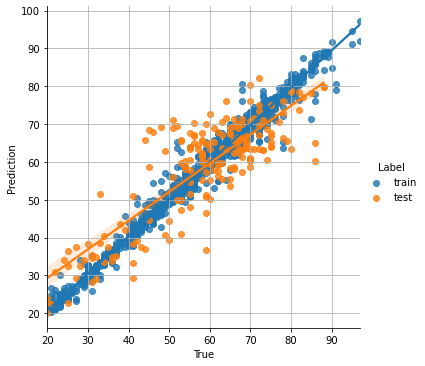

MSE  :: [TRAIN] 1.237 | [VALID] 72.342
RMSE :: [TRAIN] 0.712  | [VALID] 8.454
CORR :: [TRAIN] 0.993 | [VALID] 0.843

EPOCHS 112 / 200
MAE  :: [TRAIN] 0.501   | [TEST] 6.907
EPOCHS 113 / 200
MAE  :: [TRAIN] 0.500   | [TEST] 6.843
EPOCHS 114 / 200
MAE  :: [TRAIN] 0.484   | [TEST] 6.856
EPOCHS 115 / 200
MAE  :: [TRAIN] 0.475   | [TEST] 6.865
EPOCHS 116 / 200
MAE  :: [TRAIN] 0.489   | [TEST] 6.839


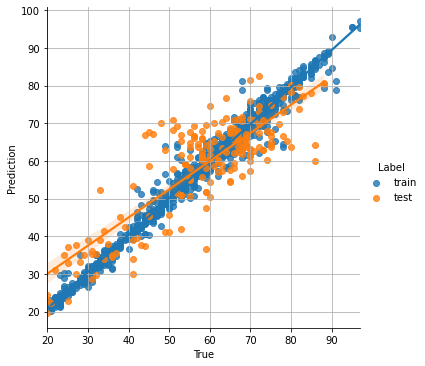

MSE  :: [TRAIN] 1.256 | [VALID] 72.610
RMSE :: [TRAIN] 0.713  | [VALID] 8.468
CORR :: [TRAIN] 0.993 | [VALID] 0.841

EPOCHS 117 / 200
MAE  :: [TRAIN] 0.499   | [TEST] 6.898
EPOCHS 118 / 200
MAE  :: [TRAIN] 0.503   | [TEST] 6.923
EPOCHS 119 / 200
MAE  :: [TRAIN] 0.501   | [TEST] 6.841
EPOCHS 120 / 200
MAE  :: [TRAIN] 0.497   | [TEST] 6.806


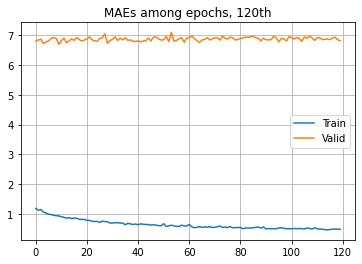

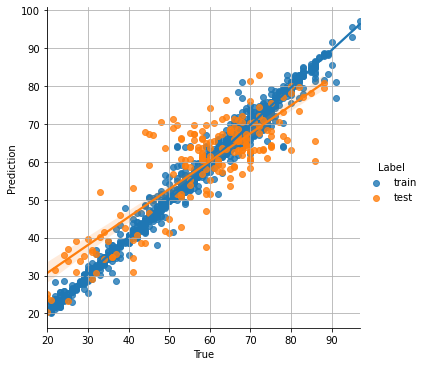

EPOCHS 121 / 200
MAE  :: [TRAIN] 0.525   | [TEST] 6.926


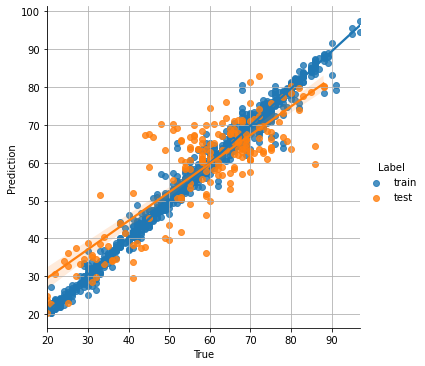

MSE  :: [TRAIN] 1.273 | [VALID] 73.528
RMSE :: [TRAIN] 0.741  | [VALID] 8.522
CORR :: [TRAIN] 0.994 | [VALID] 0.840

EPOCHS 122 / 200
MAE  :: [TRAIN] 0.501   | [TEST] 6.833
EPOCHS 123 / 200
MAE  :: [TRAIN] 0.505   | [TEST] 6.927
EPOCHS 124 / 200
MAE  :: [TRAIN] 0.494   | [TEST] 6.860
EPOCHS 125 / 200
MAE  :: [TRAIN] 0.494   | [TEST] 6.973
EPOCHS 126 / 200
MAE  :: [TRAIN] 0.516   | [TEST] 6.878


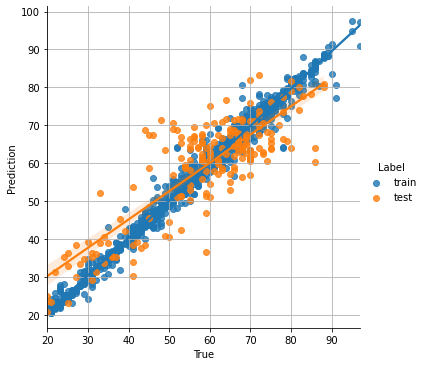

MSE  :: [TRAIN] 1.251 | [VALID] 73.211
RMSE :: [TRAIN] 0.726  | [VALID] 8.510
CORR :: [TRAIN] 0.993 | [VALID] 0.838

EPOCHS 127 / 200
MAE  :: [TRAIN] 0.515   | [TEST] 6.847
EPOCHS 128 / 200
MAE  :: [TRAIN] 0.493   | [TEST] 6.840
EPOCHS 129 / 200
MAE  :: [TRAIN] 0.480   | [TEST] 6.847
EPOCHS 130 / 200
MAE  :: [TRAIN] 0.461   | [TEST] 6.945


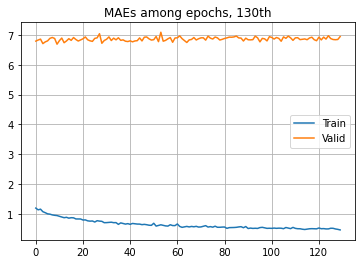

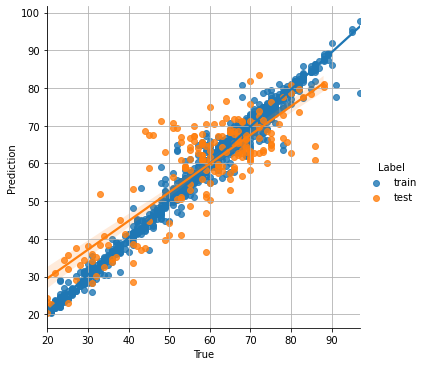

EPOCHS 131 / 200
MAE  :: [TRAIN] 0.459   | [TEST] 6.918


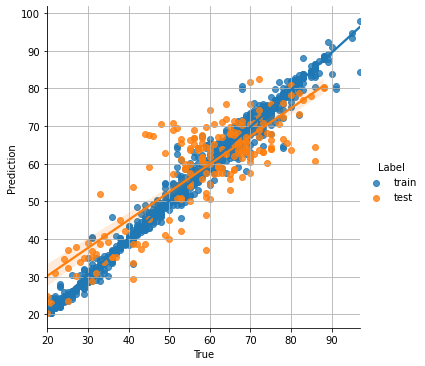

MSE  :: [TRAIN] 1.182 | [VALID] 73.245
RMSE :: [TRAIN] 0.662  | [VALID] 8.510
CORR :: [TRAIN] 0.993 | [VALID] 0.838

EPOCHS 132 / 200
MAE  :: [TRAIN] 0.504   | [TEST] 6.966
EPOCHS 133 / 200
MAE  :: [TRAIN] 0.487   | [TEST] 6.945
EPOCHS 134 / 200
MAE  :: [TRAIN] 0.477   | [TEST] 6.856
EPOCHS 135 / 200
MAE  :: [TRAIN] 0.461   | [TEST] 6.850
EPOCHS 136 / 200
MAE  :: [TRAIN] 0.473   | [TEST] 6.909


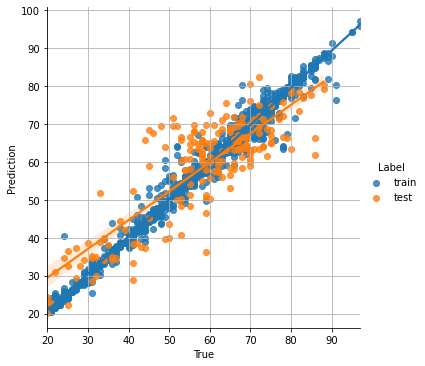

MSE  :: [TRAIN] 1.191 | [VALID] 72.463
RMSE :: [TRAIN] 0.671  | [VALID] 8.460
CORR :: [TRAIN] 0.992 | [VALID] 0.843

EPOCHS 137 / 200
MAE  :: [TRAIN] 0.482   | [TEST] 6.821
EPOCHS 138 / 200
MAE  :: [TRAIN] 0.477   | [TEST] 6.893
EPOCHS 139 / 200
MAE  :: [TRAIN] 0.480   | [TEST] 6.992
EPOCHS 140 / 200
MAE  :: [TRAIN] 0.480   | [TEST] 6.931


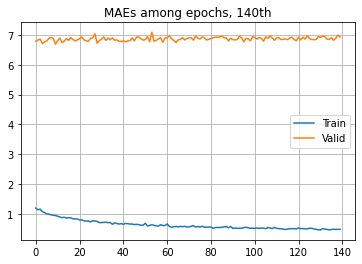

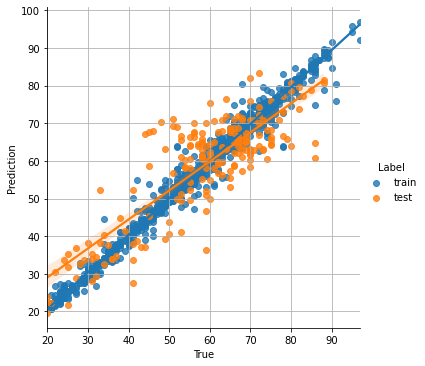

EPOCHS 141 / 200
MAE  :: [TRAIN] 0.477   | [TEST] 6.902


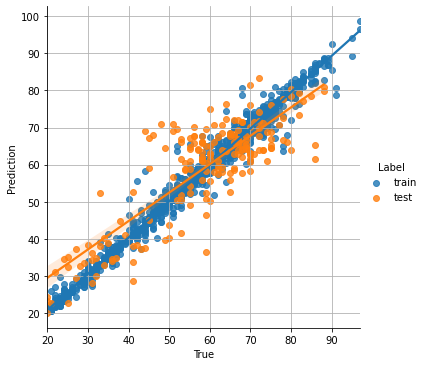

MSE  :: [TRAIN] 1.214 | [VALID] 73.422
RMSE :: [TRAIN] 0.689  | [VALID] 8.520
CORR :: [TRAIN] 0.992 | [VALID] 0.841

EPOCHS 142 / 200
MAE  :: [TRAIN] 0.479   | [TEST] 6.941
EPOCHS 143 / 200
MAE  :: [TRAIN] 0.463   | [TEST] 6.998
EPOCHS 144 / 200
MAE  :: [TRAIN] 0.479   | [TEST] 6.788
EPOCHS 145 / 200
MAE  :: [TRAIN] 0.497   | [TEST] 6.827
EPOCHS 146 / 200
MAE  :: [TRAIN] 0.489   | [TEST] 6.855


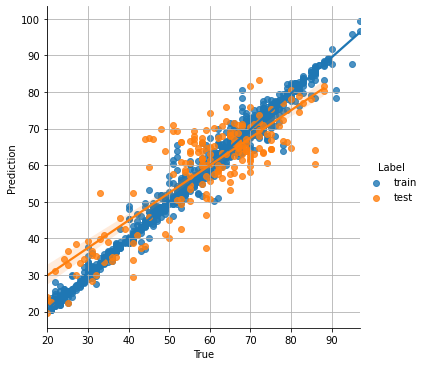

MSE  :: [TRAIN] 1.221 | [VALID] 72.095
RMSE :: [TRAIN] 0.695  | [VALID] 8.446
CORR :: [TRAIN] 0.992 | [VALID] 0.841

EPOCHS 147 / 200
MAE  :: [TRAIN] 0.495   | [TEST] 6.898
EPOCHS 148 / 200
MAE  :: [TRAIN] 0.485   | [TEST] 7.001
EPOCHS 149 / 200
MAE  :: [TRAIN] 0.459   | [TEST] 6.937
EPOCHS 150 / 200
MAE  :: [TRAIN] 0.463   | [TEST] 6.879


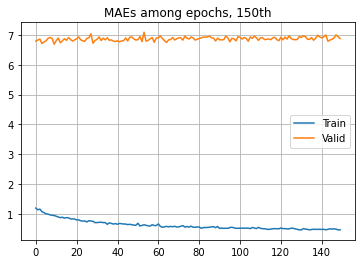

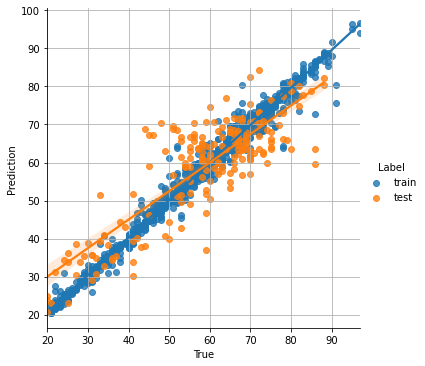

EPOCHS 151 / 200
MAE  :: [TRAIN] 0.498   | [TEST] 6.813


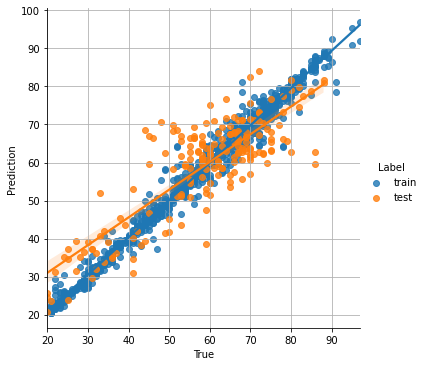

MSE  :: [TRAIN] 1.239 | [VALID] 72.559
RMSE :: [TRAIN] 0.708  | [VALID] 8.473
CORR :: [TRAIN] 0.993 | [VALID] 0.837

EPOCHS 152 / 200
MAE  :: [TRAIN] 0.488   | [TEST] 6.802
EPOCHS 153 / 200
MAE  :: [TRAIN] 0.467   | [TEST] 6.862
EPOCHS 154 / 200
MAE  :: [TRAIN] 0.450   | [TEST] 6.920
EPOCHS 155 / 200
MAE  :: [TRAIN] 0.441   | [TEST] 6.911
EPOCHS 156 / 200
MAE  :: [TRAIN] 0.477   | [TEST] 6.971


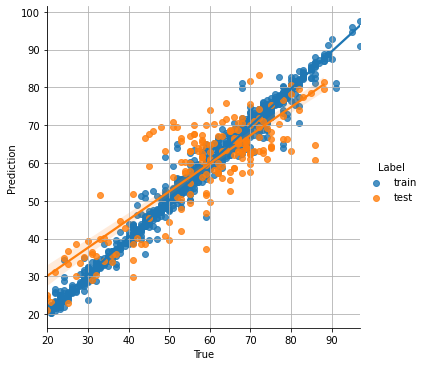

MSE  :: [TRAIN] 1.220 | [VALID] 73.976
RMSE :: [TRAIN] 0.690  | [VALID] 8.539
CORR :: [TRAIN] 0.993 | [VALID] 0.839

EPOCHS 157 / 200
MAE  :: [TRAIN] 0.492   | [TEST] 6.828
EPOCHS 158 / 200
MAE  :: [TRAIN] 0.456   | [TEST] 6.992
EPOCHS 159 / 200
MAE  :: [TRAIN] 0.445   | [TEST] 6.858
EPOCHS 160 / 200
MAE  :: [TRAIN] 0.450   | [TEST] 6.905


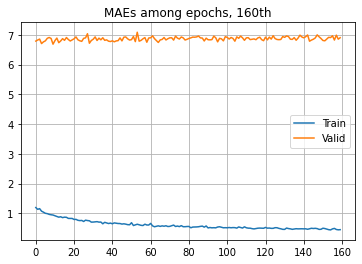

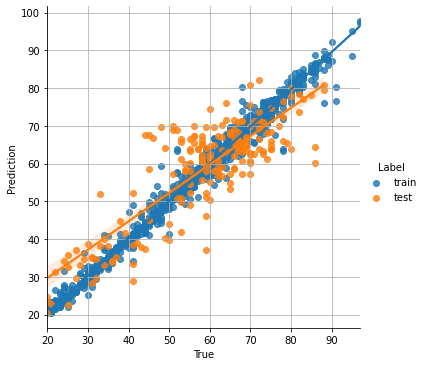

EPOCHS 161 / 200
MAE  :: [TRAIN] 0.434   | [TEST] 6.860


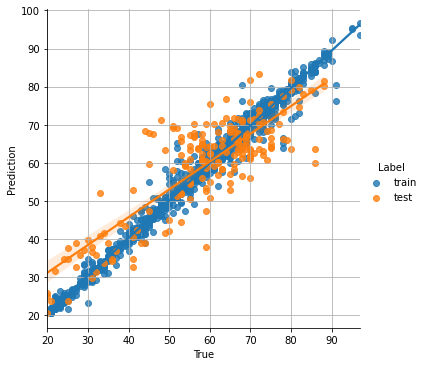

MSE  :: [TRAIN] 1.160 | [VALID] 73.507
RMSE :: [TRAIN] 0.637  | [VALID] 8.517
CORR :: [TRAIN] 0.993 | [VALID] 0.837

EPOCHS 162 / 200
MAE  :: [TRAIN] 0.457   | [TEST] 6.951
EPOCHS 163 / 200
MAE  :: [TRAIN] 0.457   | [TEST] 6.882
EPOCHS 164 / 200
MAE  :: [TRAIN] 0.492   | [TEST] 6.761
EPOCHS 165 / 200
MAE  :: [TRAIN] 0.490   | [TEST] 6.791
EPOCHS 166 / 200
MAE  :: [TRAIN] 0.488   | [TEST] 6.853


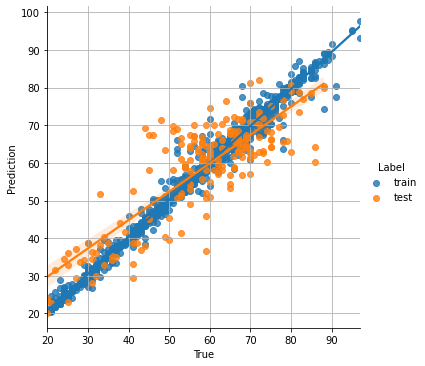

MSE  :: [TRAIN] 1.209 | [VALID] 72.717
RMSE :: [TRAIN] 0.686  | [VALID] 8.487
CORR :: [TRAIN] 0.993 | [VALID] 0.839

EPOCHS 167 / 200
MAE  :: [TRAIN] 0.480   | [TEST] 6.741
EPOCHS 168 / 200
MAE  :: [TRAIN] 0.448   | [TEST] 6.816
EPOCHS 169 / 200
MAE  :: [TRAIN] 0.445   | [TEST] 6.771
EPOCHS 170 / 200
MAE  :: [TRAIN] 0.475   | [TEST] 6.879


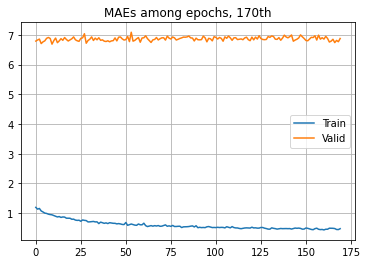

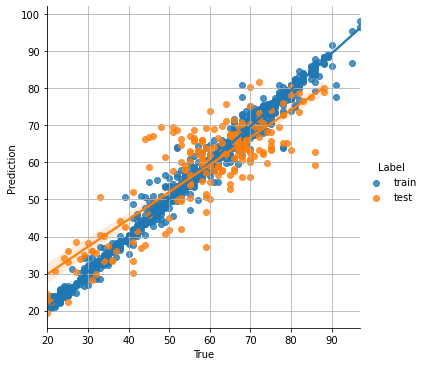

EPOCHS 171 / 200
MAE  :: [TRAIN] 0.467   | [TEST] 6.761


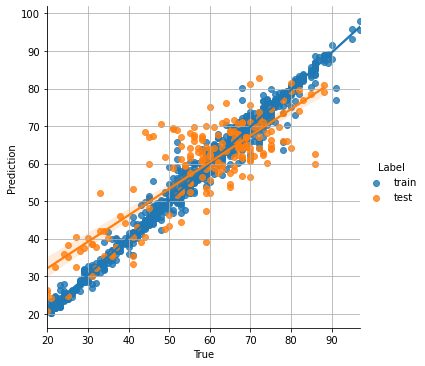

MSE  :: [TRAIN] 1.187 | [VALID] 71.971
RMSE :: [TRAIN] 0.667  | [VALID] 8.426
CORR :: [TRAIN] 0.993 | [VALID] 0.837

EPOCHS 172 / 200
MAE  :: [TRAIN] 0.477   | [TEST] 6.825
EPOCHS 173 / 200
MAE  :: [TRAIN] 0.458   | [TEST] 6.868
EPOCHS 174 / 200
MAE  :: [TRAIN] 0.458   | [TEST] 6.717
EPOCHS 175 / 200
MAE  :: [TRAIN] 0.487   | [TEST] 6.682
EPOCHS 176 / 200
MAE  :: [TRAIN] 0.495   | [TEST] 6.793


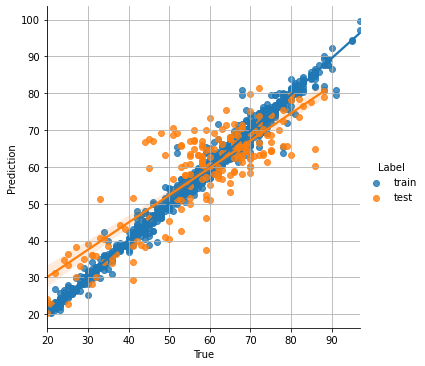

MSE  :: [TRAIN] 1.230 | [VALID] 70.264
RMSE :: [TRAIN] 0.708  | [VALID] 8.335
CORR :: [TRAIN] 0.994 | [VALID] 0.844

EPOCHS 177 / 200
MAE  :: [TRAIN] 0.470   | [TEST] 6.763
EPOCHS 178 / 200
MAE  :: [TRAIN] 0.475   | [TEST] 6.754
EPOCHS 179 / 200
MAE  :: [TRAIN] 0.462   | [TEST] 6.852
EPOCHS 180 / 200
MAE  :: [TRAIN] 0.472   | [TEST] 6.801


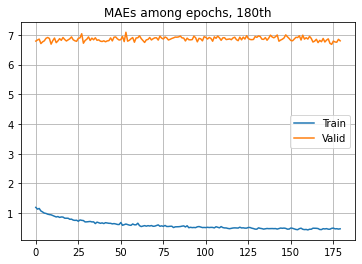

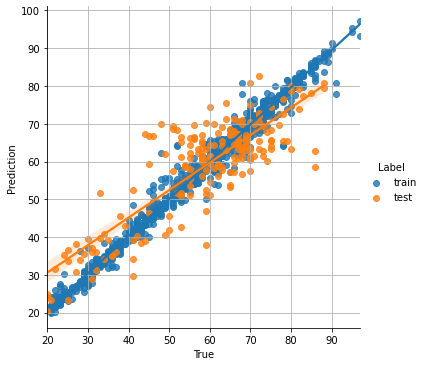

EPOCHS 181 / 200
MAE  :: [TRAIN] 0.460   | [TEST] 6.921


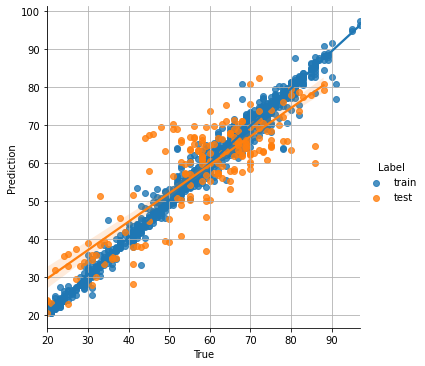

MSE  :: [TRAIN] 1.187 | [VALID] 72.544
RMSE :: [TRAIN] 0.667  | [VALID] 8.471
CORR :: [TRAIN] 0.993 | [VALID] 0.841

EPOCHS 182 / 200
MAE  :: [TRAIN] 0.455   | [TEST] 6.852
EPOCHS 183 / 200
MAE  :: [TRAIN] 0.462   | [TEST] 6.831
EPOCHS 184 / 200
MAE  :: [TRAIN] 0.445   | [TEST] 6.865
EPOCHS 185 / 200
MAE  :: [TRAIN] 0.457   | [TEST] 6.752
EPOCHS 186 / 200
MAE  :: [TRAIN] 0.470   | [TEST] 6.839


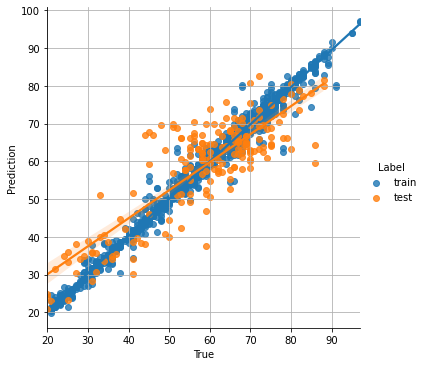

MSE  :: [TRAIN] 1.202 | [VALID] 71.287
RMSE :: [TRAIN] 0.682  | [VALID] 8.395
CORR :: [TRAIN] 0.993 | [VALID] 0.843

EPOCHS 187 / 200
MAE  :: [TRAIN] 0.443   | [TEST] 6.810
EPOCHS 188 / 200
MAE  :: [TRAIN] 0.435   | [TEST] 6.889
EPOCHS 189 / 200
MAE  :: [TRAIN] 0.421   | [TEST] 6.803
EPOCHS 190 / 200
MAE  :: [TRAIN] 0.470   | [TEST] 6.824


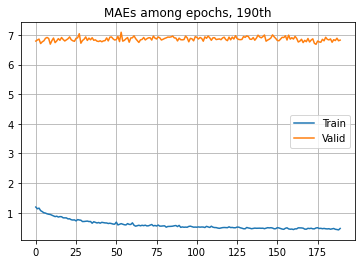

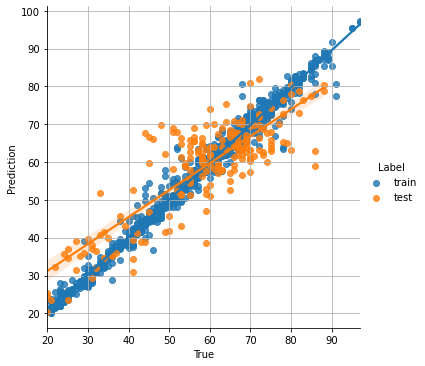

EPOCHS 191 / 200
MAE  :: [TRAIN] 0.457   | [TEST] 6.801


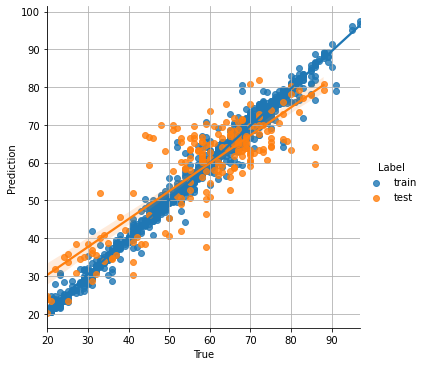

MSE  :: [TRAIN] 1.176 | [VALID] 70.837
RMSE :: [TRAIN] 0.656  | [VALID] 8.375
CORR :: [TRAIN] 0.993 | [VALID] 0.843

EPOCHS 192 / 200
MAE  :: [TRAIN] 0.462   | [TEST] 6.800
EPOCHS 193 / 200
MAE  :: [TRAIN] 0.418   | [TEST] 6.759
EPOCHS 194 / 200
MAE  :: [TRAIN] 0.425   | [TEST] 6.886
EPOCHS 195 / 200
MAE  :: [TRAIN] 0.450   | [TEST] 6.797
EPOCHS 196 / 200
MAE  :: [TRAIN] 0.456   | [TEST] 6.757


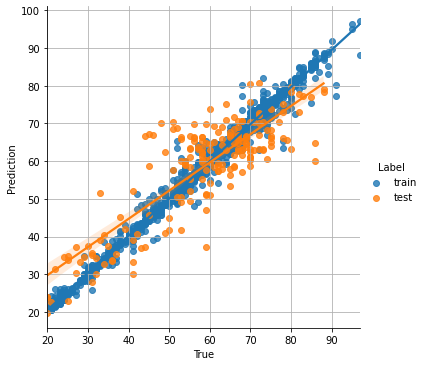

MSE  :: [TRAIN] 1.172 | [VALID] 69.523
RMSE :: [TRAIN] 0.655  | [VALID] 8.297
CORR :: [TRAIN] 0.994 | [VALID] 0.846

EPOCHS 197 / 200
MAE  :: [TRAIN] 0.451   | [TEST] 6.750
EPOCHS 198 / 200
MAE  :: [TRAIN] 0.411   | [TEST] 6.806
EPOCHS 199 / 200
MAE  :: [TRAIN] 0.414   | [TEST] 6.801
EPOCHS 200 / 200
MAE  :: [TRAIN] 0.429   | [TEST] 6.850


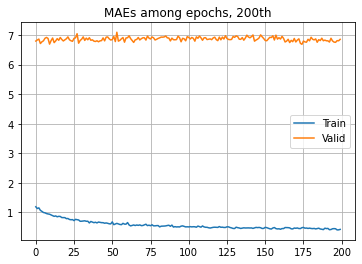

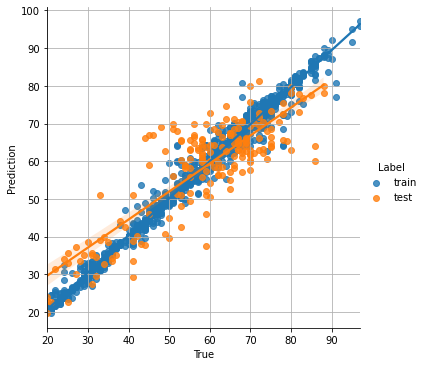

In [9]:
model_name = 'resnet'
# model, device = load_model(model_name)

model = torch.load('./models/resnet_200_elastic_6.949.pth')
optimizer = optim.Adam(model.parameters(), lr=1e-5)

trn_losses, trn_maes, trn_rmses = [], [], []
aug_losses, aug_maes, aug_rmses = [], [], []
tst_losses, tst_maes, tst_rmses = [], [], []

best_mae = 7
fold = None
batch_size = 16
for e in epochs:

    model, (trn_losses, trn_maes, trn_rmses), trn_preds = train(model, False, None, fold, resize, device, batch_size,
                                                                loss_fn, mae_fn, rmse_fn,
                                                                trn_losses, trn_maes, trn_rmses,
                                                                optimizer, scheduler, lamb)

    model, (aug_losses, aug_maes, aug_rmses), aug_preds = train(model, False, True, fold, resize, device, batch_size,
                                                                loss_fn, mae_fn, rmse_fn,
                                                                aug_losses, aug_maes, aug_rmses,
                                                                optimizer, scheduler, lamb)
    
    model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, True, None, fold, resize, device, batch_size,
                                                           loss_fn, mae_fn, rmse_fn,
                                                           tst_losses, tst_maes, tst_rmses)

    # SUM UP RESLUTS
    trn_df = make_df(trn_preds, 'train')
    aug_df = make_df(aug_preds, 'train')
    tst_df = make_df(tst_preds, 'test')
    reg_df = pd.concat([trn_df, tst_df, aug_df], ignore_index=True)

    trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
    tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
    
    if tst_maes[-1] < best_mae:
        torch.save(model, f'./models/{model_name}_{e+200}_elastic_{tst_maes[-1]:.3f}.pth')
        best_mae = tst_maes[-1]

#     print(f'FOLD {fold} - EPOCHS {e}')
    print(f'EPOCHS {e+1} / {epochs.stop}')
    print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [TEST] {tst_maes[-1]:.3f}')
    
    if e % 5 == 0:
        
        sns_plot = sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#         sns_plot.savefig(f'{fold}.png')
        plt.grid()
        plt.show()
        
        print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
        print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {tst_rmses[-1]:.3f}')
        print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}\n')

    if e % 10 == 9:
#         plt.title(f"L1 Losses among epochs, {e}th")
#         plt.plot(trn_losses, label='Train')
#         plt.plot(tst_losses, label='Valid')
        
        plt.title(f"MAEs among epochs, {e+1}th")
        plt.plot(trn_maes, label='Train')
        plt.plot(tst_maes, label='Valid')
        plt.grid()
        plt.legend()

        sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()

torch.save(model, f'./models/{model_name}_{e}_elastic_{tst_maes[-1]}.pth')

# del model
torch.cuda.empty_cache()

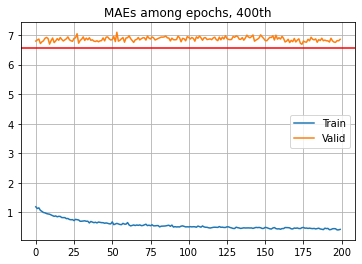

In [19]:
plt.title(f"MAEs among epochs, {e+1+200}th")
plt.plot(trn_maes, label='Train')
plt.plot(tst_maes, label='Valid')
plt.axhline(y=6.57, color='r', linestyle='-')
plt.grid()
plt.legend()

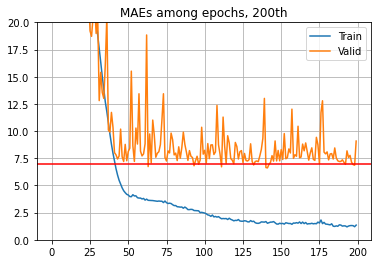

In [12]:
plt.title(f"MAEs among epochs, {e+1}th")
plt.plot(trn_maes, label='Train')
plt.plot(tst_maes, label='Valid')
plt.axhline(y=7, color='r', linestyle='-')
plt.ylim(0, 20)
plt.grid()
plt.legend()

### + Inference - M3dcam

In [ ]:
model = medcam.inject(model, output_dir="attention_maps/", save_maps=False, retain_graph=True, layer='layer1')
model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, True, None, fold, resize, device, 1,
                                                       loss_fn, mae_fn, rmse_fn,
                                                       tst_losses, tst_maes, tst_rmses)

### kFold Run

In [ ]:
# best_loss = 10

# trn_fold_losses, tst_fold_losses = [], []
# trn_fold_corrs, tst_fold_corrs = [], []

# trn_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# val_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# tst_losses, tst_maes, tst_rmses = [], [], []
# for fold in folds:
    
#     model_name = 'resnet'
#     model, device = load_model(model_name)
#     optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
#     trn_losses, val_losses = [], []
#     trn_maes, val_maes = [], []
#     trn_rmses, val_rmses = [], []
    
#     aug_losses, aug_maes, aug_rmses = [], [], []
    
#     for e in epochs:

#         model, (trn_losses, trn_maes, trn_rmses), trn_preds = train(model, False, None, fold, resize, device,
#                                                               loss_fn, mae_fn, rmse_fn,
#                                                               trn_losses, trn_maes, trn_rmses,
#                                                               optimizer, scheduler, lamb)
        
#         model, (aug_losses, aug_maes, aug_rmses), aug_preds = train(model, False, True, fold, resize, device,
#                                                               loss_fn, mae_fn, rmse_fn,
#                                                               aug_losses, aug_maes, aug_rmses,
#                                                               optimizer, scheduler, lamb)
        
#         model, (val_losses, val_maes, val_rmses), val_preds =  eval(model, True, None, fold, resize, device,
#                                                               loss_fn, mae_fn, rmse_fn,
#                                                               val_losses, val_maes, val_rmses)


#         # SUM UP RESLUTS
#         trn_df = make_df(trn_preds, 'train')
#         val_df = make_df(val_preds, 'valid')
#         aug_df = make_df(aug_preds, 'train')
#         reg_df = pd.concat([trn_df, val_df, aug_df], ignore_index=True)

#         trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
#         val_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

        
#         print(f'FOLD {fold} - EPOCHS {e}')
#         print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [VALID] {val_maes[-1]:.3f}')
#         if e % 5 == 0:
#             print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {val_losses[-1]:.3f}')
#             print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {val_rmses[-1]:.3f}')
#             print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {val_corr:.3f}\n')

#         if e % 10 == 9:
#             plt.title(f"L1 Losses among epochs, {e}th")
#             plt.plot(trn_losses, label='Train')
#             plt.plot(val_losses, label='Valid')
#             plt.grid(); plt.legend()
            
#             sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#             plt.grid()
#             plt.show()
    
#     torch.save(model, f'./models/{model_name}_1222_{fold}_{e}_{trn_losses[-1]}.pth')
    
#     trn_fold['MSE'].append(trn_losses)
#     trn_fold['MAE'].append(trn_maes)
#     trn_fold['RMSE'].append(trn_rmses)
#     trn_fold['Correlation'].append(trn_corr)
    
#     val_fold['MSE'].append(val_losses)
#     val_fold['MAE'].append(val_maes)
#     val_fold['RMSE'].append(val_rmses)
#     val_fold['Correlation'].append(val_corr)
    
#     # TEST
#     test_dset = MyDataset(task_type='age', test=True)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, test_loader, resize, device,
#                                                               loss_fn, mae_fn, rmse_fn,
#                                                               tst_losses, tst_maes, tst_rmses)

#     tst_df = make_df(tst_preds, 'test')
#     reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

#     tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
    
#     print(f'FOLD {fold}', end='')
#     print(f'MSE  :: [TEST] {tst_losses[-1]:.3f}')
#     print(f'MAE  :: [TEST] {tst_maes[-1]:.3f}')
#     print(f'RMSE :: [TEST] {tst_rmses[-1]:.3f}')
#     print(f'CORR :: [TEST] {tst_corr:.3f}')
    
#     torch.save(model, f'./models/{model_name}_{tst_maes[-1]}.pth')

#     sns_plot = sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#     sns_plot.savefig(f'{fold}.png')
#     plt.grid()
#     plt.show()
    
#     del model
#     torch.cuda.empty_cache()

In [ ]:
# torch.save(model, 'model.pth')

In [ ]:
# best_loss = 10

# trn_fold_losses, tst_fold_losses = [], []
# trn_fold_corrs, tst_fold_corrs = [], []

# trn_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# tst_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# for fold in folds:
    
#     train_dset = MyDataset(task_type='age', fold=fold)
#     test_dset = MyDataset(task_type='age', test=True, fold=fold)

#     train_loader = DataLoader(train_dset, batch_size=8)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     trn_losses, tst_losses = [], []
#     trn_maes, tst_maes = [], []
#     trn_rmses, tst_rmses = [], []
#     for e in epochs:

#         # TRAIN
#         trn_bth_loss, trn_bth_mae, trn_bth_rmse = 0, 0, 0
#         trn_trues, trn_preds = [], []
#         model.train()
#         for i, (x, y) in enumerate(train_loader):

#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             optimizer.zero_grad()

#             y_pred = model.forward(x).to(device)

#             trn_trues.append(y.to('cpu'))
#             trn_preds.append(y_pred.to('cpu'))

#             # Loss
#             loss = loss_fn(y_pred.squeeze(1), y)
            
#             # Metrics
#             mae = mae_fn(y_pred.squeeze(1), y)
#             rmse = rmse_fn(y_pred.squeeze(1), y)
            
#             del x, y, y_pred

#             loss.backward()
#             optimizer.step()
#             if scheduler: scheduler.step()

#             trn_bth_loss += loss.item()
#             trn_bth_mae  += loss.item()
#             trn_bth_rmse += loss.item()

#         torch.cuda.empty_cache()

#         ### loss
#         trn_losses.append(trn_bth_loss / len(train_loader))
#         trn_maes.append(trn_bth_mae / len(train_loader))
#         trn_rmses.append(trn_bth_rmse / len(train_loader))

#         ### collect trues/predictions
#         trn_trues = list(chain(*trn_trues))
#         trn_preds = list(chain(*trn_preds))

        
#         # VALID
#         tst_bth_loss, tst_bth_mae, tst_bth_rmse = 0, 0, 0
#         model.eval()
#         tst_trues, tst_preds = [], []
#         with torch.no_grad(): # to not give loads on GPU... :(
#             for i, (x, y) in enumerate(test_loader):
#                 if resize:
#                     x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#                 else:
#                     x, y = x.to(device), y.to(device)

#                 y_pred = model.forward(x).to(device)

#                 tst_trues.append(y.to('cpu'))
#                 tst_preds.append(y_pred.to('cpu'))

#                 # Loss
#                 loss = loss_fn(y_pred.squeeze(1), y)
                
#                 # Metrics
#                 mae = mae_fn(y_pred.squeeze(1), y)
#                 rmse = rmse_fn(y_pred.squeeze(1), y)
                
#                 del x, y, y_pred

#                 tst_bth_loss += loss.item()
#                 tst_bth_mae  += loss.item()
#                 tst_bth_rmse += loss.item()
                
#         torch.cuda.empty_cache()
        
#         ### loss
#         tst_losses.append(tst_bth_loss / len(test_loader))
#         tst_maes.append(tst_bth_mae / len(test_loader))
#         tst_rmses.append(tst_bth_rmse / len(test_loader))

#         ### collect trues/predictions
#         tst_trues = list(chain(*tst_trues))
#         tst_preds = list(chain(*tst_preds))

        
#         # SUM UP RESLUTS
#         reg_df = pd.DataFrame({
#             'True': list(map(float, trn_trues + tst_trues)),
#             'Prediction': list(map(float, trn_preds + tst_preds)),
#             'Label': ['train'] * len(trn_trues) + ['valid'] * len(tst_trues)
#         })

#         trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
#         tst_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

#         if e % 5 == 0:
#             print(f'FOLD {fold} - EPOCHS {e}')
#             print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
#             print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [VALID] {tst_maes[-1]:.3f}')
#             print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {tst_rmses[-1]:.3f}')
#             print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}')

#         if e % 10 == 9:
#             plt.title(f"L1 Losses among epochs, {e}th")
#             plt.plot(trn_losses, label='Train')
#             plt.plot(tst_losses, label='Valid')
#             plt.grid(); plt.legend()
            
#             sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#             plt.grid()
#             plt.show()
    
#     trn_fold['MSE'].append(trn_losses)
#     trn_fold['MAE'].append(trn_maes)
#     trn_fold['RMSE'].append(trn_rmses)
#     trn_fold['Correlation'].append(trn_corr)
    
#     tst_fold['MSE'].append(tst_losses)
#     tst_fold['MAE'].append(tst_maes)
#     tst_fold['RMSE'].append(tst_rmses)
#     tst_fold['Correlation'].append(tst_corr)
    
#     # TEST
#     test_dset = MyDataset(task_type='age', test=True)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     tst_bth_loss = 0
#     model.eval()
#     tst_trues, tst_preds = [], []
#     with torch.no_grad(): # to not give loads on GPU... :(
#         for i, (x, y) in enumerate(test_loader):
#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             y_pred = model.forward(x).to(device)

#             tst_trues.append(y.to('cpu'))
#             tst_preds.append(y_pred.to('cpu'))

#             loss = loss_fn(y_pred.squeeze(1), y)
            
#             mae = mae_fn(y_pred.squeeze(1), y)
#             rmse = rmse_fn(y_pred.squeeze(1), y)
#             del x, y, y_pred

#             tst_bth_loss += loss.item()

#     torch.cuda.empty_cache()
#     ### loss
#     tst_loss = tst_bth_loss / len(test_loader)

#     ### collect trues/predictions
#     tst_trues = list(chain(*tst_trues))
#     tst_preds = list(chain(*tst_preds))
    
#     tst_df = pd.DataFrame({
#         'True': list(map(float, tst_trues)),
#         'Prediction': list(map(float, tst_preds)),
#         'Label': ['test'] * len(tst_trues)
#     })
#     reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

#     tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
#     print(f'FOLD {fold}', end='')
#     print(f'RMSE :: [TEST] {tst_loss:.3f}')
#     print(f'CORR :: [TEST] {tst_corr:.3f}')

#     sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#     plt.grid()
#     plt.show()